In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/rollnumber_A2_Q2

/content/drive/My Drive/rollnumber_A2_Q2


In [ ]:
!ls

A2_Q2.ipynb  frames  results  videos


In [ ]:
import numpy as np
from scipy.stats import multivariate_normal

class GMM:
    def __init__(self, n_components=2, tol=1e-3, max_iter=100):
        self.n_components = n_components
        self.tol = tol
        self.max_iter = max_iter
        self.weights = None
        self.means = None
        self.covariances = None
        self.converged = False

    def initialize_params(self, X):
        n_samples, n_features = X.shape
        self.weights = np.ones(self.n_components) / self.n_components
        self.means = X[np.random.choice(n_samples, self.n_components, False)]
        self.covariances = np.array([np.eye(n_features) * 1e-6 for _ in range(self.n_components)])

    def e_step(self, X):
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))
        for k in range(self.n_components):
            try:
                rv = multivariate_normal(mean=self.means[k], cov=self.covariances[k], allow_singular=True)
                responsibilities[:, k] = self.weights[k] * rv.pdf(X)
            except np.linalg.LinAlgError:
                responsibilities[:, k] = np.zeros(n_samples)
        responsibilities /= np.maximum(responsibilities.sum(axis=1)[:, np.newaxis], 1e-10)
        return responsibilities

    def m_step(self, X, responsibilities):
        n_samples, n_features = X.shape
        weights = responsibilities.sum(axis=0)
        self.weights = weights / n_samples
        self.means = np.dot(responsibilities.T, X) / weights[:, np.newaxis]

        reg_covar = 1e-6
        for k in range(self.n_components):
            diff = X - self.means[k]
            covar_k = np.dot(responsibilities[:, k] * diff.T, diff) / weights[k]
            covar_k += np.eye(n_features) * 1
            self.covariances[k] = covar_k

    def log_likelihood(self, X):
        log_likelihood = 0
        for k in range(self.n_components):
            try:
                rv = multivariate_normal(mean=self.means[k], cov=self.covariances[k], allow_singular=True)
                log_likelihood += np.sum(np.log(rv.pdf(X) * self.weights[k] + 1e-10))
            except np.linalg.LinAlgError:
                pass
        return log_likelihood

    def fit(self, X):
        self.initialize_params(X)
        log_likelihood_old = 0
        for iteration in range(self.max_iter):
            responsibilities = self.e_step(X)
            self.m_step(X, responsibilities)
            log_likelihood_new = self.log_likelihood(X)
            if np.abs(log_likelihood_new - log_likelihood_old) < self.tol:
                self.converged = True
                break
            log_likelihood_old = log_likelihood_new

    def predict(self, X):
        responsibilities = self.e_step(X)
        return np.argmax(responsibilities, axis=1)


In [ ]:
%cd /content/drive/My Drive/rollnumber_A2_Q2

/content/drive/My Drive/rollnumber_A2_Q2


In [ ]:
!ls

A2_Q2.ipynb  frames  results  videos


In [ ]:
!ls frames/traffic

frame_0001.png	frame_0015.png	frame_0029.png	frame_0043.png	frame_0057.png	frame_0071.png
frame_0002.png	frame_0016.png	frame_0030.png	frame_0044.png	frame_0058.png	frame_0072.png
frame_0003.png	frame_0017.png	frame_0031.png	frame_0045.png	frame_0059.png	frame_0073.png
frame_0004.png	frame_0018.png	frame_0032.png	frame_0046.png	frame_0060.png	frame_0074.png
frame_0005.png	frame_0019.png	frame_0033.png	frame_0047.png	frame_0061.png	frame_0075.png
frame_0006.png	frame_0020.png	frame_0034.png	frame_0048.png	frame_0062.png	frame_0076.png
frame_0007.png	frame_0021.png	frame_0035.png	frame_0049.png	frame_0063.png	frame_0077.png
frame_0008.png	frame_0022.png	frame_0036.png	frame_0050.png	frame_0064.png	frame_0078.png
frame_0009.png	frame_0023.png	frame_0037.png	frame_0051.png	frame_0065.png	frame_0079.png
frame_0010.png	frame_0024.png	frame_0038.png	frame_0052.png	frame_0066.png	frame_0080.png
frame_0011.png	frame_0025.png	frame_0039.png	frame_0053.png	frame_0067.png
frame_0012.png	frame_0026

In [ ]:
source_folder = 'videos'
video = 'traffic.gif'

source_path = f'./{source_folder}/{video}'

In [ ]:
data_folder = 'frames'

frames_path = f"./{data_folder}/{video.rsplit('.', 1)[0]}"

In [ ]:
%%capture

!mkdir -p {frames_path} > /dev/null ;

In [ ]:
%%capture

!ffmpeg -i {source_path} {frames_path}/'frame_%04d.png' > /dev/null ;

In [ ]:
import glob

frames = []

for file_path in sorted(glob.glob(f'{frames_path}/*.png', recursive = False)):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = np.asarray(img, dtype=np.float64)
    img /= 255.0

    frames.append(img)

frames = np.asarray(frames, dtype=np.float64)

In [ ]:
from sklearn.model_selection import train_test_split

print(f'frame: {frames.shape}')

train_frames, test_frames = train_test_split(frames, train_size=0.6, shuffle=False) # Do Not Shuffle!

print(f'train_frames: {train_frames.shape}')
print(f'test_frames: {test_frames.shape}')

frame: (80, 120, 160, 3)
train_frames: (48, 120, 160, 3)
test_frames: (32, 120, 160, 3)


In [ ]:
import imageio

def make_gif(img_list, gif_path, fps=10):
    imageio.mimsave(gif_path, img_list, fps=fps)
    return

In [ ]:
import imageio

def make_gif(img_list, gif_path, fps=10):
    imageio.mimsave(gif_path, img_list, fps=fps)
    return

In [ ]:
import numpy as np

def extract_background_frame_averaging(train_frames):
    background = np.mean(train_frames, axis=0)
    return background


In [ ]:
import numpy as np
import cv2
import glob
import imageio

background_image = extract_background_frame_averaging(train_frames)



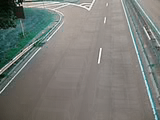

In [ ]:
from google.colab.patches import cv2_imshow

background_image_uint8 = (background_image * 255).astype('uint8')

cv2_imshow(background_image_uint8)


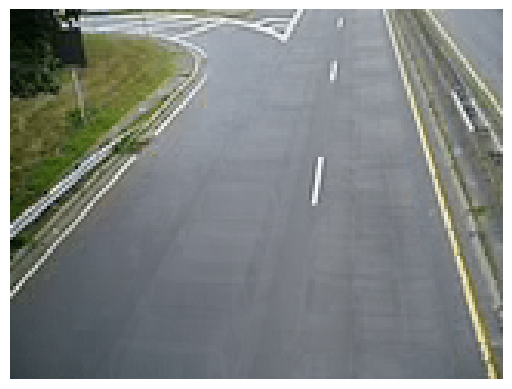

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(background_image)
plt.axis('off')
plt.show()


In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture

def train_pixel_gmms(train_frames, n_components=2):
    n_frames, height, width, channels = train_frames.shape
    gmms = np.empty((height, width), dtype=object)

    for i in range(height):
        for j in range(width):
            pixel_series = train_frames[:, i, j, :].reshape(-1, channels)
            gmm = GaussianMixture(n_components=n_components, covariance_type='full')
            gmm.fit(pixel_series)
            gmms[i, j] = gmm

    return gmms

def extract_background_from_gmms(gmms):
    height, width = gmms.shape
    background_image = np.zeros((height, width, 3))

    for i in range(height):
        for j in range(width):
            gmm = gmms[i, j]
            background_index = np.argmax(gmm.weights_)
            background_image[i, j] = gmm.means_[background_index]

    return background_image

In [ ]:
height, width, _ = train_frames.shape[1:]
pixel_gmms = np.array([[GMM(n_components=2) for _ in range(width)] for _ in range(height)])

for i in range(height):
    for j in range(width):
        pixel_data = train_frames[:, i, j, :]
        pixel_gmms[i, j].fit(pixel_data)

In [ ]:
def extract_background_from_gmms(pixel_gmms):
    height, width = pixel_gmms.shape
    background_image = np.zeros((height, width, 3))

    for i in range(height):
        for j in range(width):
            gmm = pixel_gmms[i, j]
            background_index = np.argmax(gmm.weights)
            background_image[i, j] = gmm.means[background_index]

    return background_image

background_image = extract_background_from_gmms(pixel_gmms)


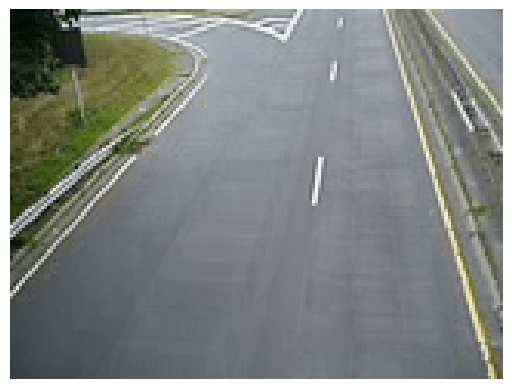

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(background_image)
plt.axis('off')
plt.show()


In [ ]:
background_gmm = background_image/255

In [ ]:
background_image

array([[[0.02312092, 0.05555556, 0.02843137],
        [0.02843137, 0.06495098, 0.03088235],
        [0.02728758, 0.0624183 , 0.03137255],
        ...,
        [0.51331699, 0.54060458, 0.57099673],
        [0.46993464, 0.50253268, 0.53161765],
        [0.45425494, 0.48276813, 0.51226201]],

       [[0.02638889, 0.06086601, 0.03088235],
        [0.01552288, 0.03406863, 0.03839869],
        [0.02238562, 0.05506536, 0.02647059],
        ...,
        [0.54183209, 0.57181571, 0.60833542],
        [0.51650434, 0.54771349, 0.57091613],
        [0.48643791, 0.51584967, 0.54852941]],

       [[0.0251634 , 0.05800654, 0.03145425],
        [0.02197712, 0.05547386, 0.02401961],
        [0.02124183, 0.05253268, 0.02696079],
        ...,
        [0.54044292, 0.5745933 , 0.60694628],
        [0.51413419, 0.55473877, 0.59411787],
        [0.51642334, 0.54477299, 0.5701815 ]],

       ...,

       [[0.21209154, 0.23782684, 0.25792489],
        [0.20841503, 0.24436275, 0.25718954],
        [0.21985312, 0

In [ ]:
import numpy as np

def extract_background_frame_averaging(train_frames):
    background = np.mean(train_frames, axis=0)
    return background

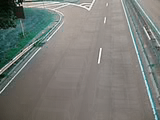

In [ ]:
cv2_imshow((extract_background_frame_averaging(train_frames) * 255).astype('uint8'))


#background_image_gmm = extract_background_from_gmms(pixel_gmms)

#background_image_uint8_gmm = (background_image_gmm * 255).astype('uint8')

In [ ]:
#background_image_uint8_gmm

In [ ]:
def apply_foreground_mask(frame, foreground_mask):
    foreground_mask = foreground_mask.astype(bool)
    foreground_rgb = np.zeros_like(frame)

    for c in range(frame.shape[2]):
        foreground_rgb[:, :, c] = frame[:, :, c] * foreground_mask

    return foreground_rgb


In [ ]:
def save_frames(frames, fps=10.0, output_path='./results', file_name='foreground'):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    height, width = frames[0].shape[:2]
    out = cv2.VideoWriter(os.path.join(output_path, f'{file_name}.mp4'), fourcc, fps, (width, height))

    for frame in frames:
        if frame.shape[2] == 3:
            frame_bgr = cv2.cvtColor((frame * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
        else:
            frame_bgr = (frame * 255).astype(np.uint8)
        out.write(frame_bgr)

    out.release()

In [ ]:

background_frame_avg = extract_background_frame_averaging(train_frames)

foreground_frames_avg = [np.abs(frame - background_frame_avg) > 0.2 for frame in test_frames]


In [ ]:
background_image

array([[[0.02312092, 0.05555556, 0.02843137],
        [0.02843137, 0.06495098, 0.03088235],
        [0.02728758, 0.0624183 , 0.03137255],
        ...,
        [0.51331699, 0.54060458, 0.57099673],
        [0.46993464, 0.50253268, 0.53161765],
        [0.45425494, 0.48276813, 0.51226201]],

       [[0.02638889, 0.06086601, 0.03088235],
        [0.01552288, 0.03406863, 0.03839869],
        [0.02238562, 0.05506536, 0.02647059],
        ...,
        [0.54183209, 0.57181571, 0.60833542],
        [0.51650434, 0.54771349, 0.57091613],
        [0.48643791, 0.51584967, 0.54852941]],

       [[0.0251634 , 0.05800654, 0.03145425],
        [0.02197712, 0.05547386, 0.02401961],
        [0.02124183, 0.05253268, 0.02696079],
        ...,
        [0.54044292, 0.5745933 , 0.60694628],
        [0.51413419, 0.55473877, 0.59411787],
        [0.51642334, 0.54477299, 0.5701815 ]],

       ...,

       [[0.21209154, 0.23782684, 0.25792489],
        [0.20841503, 0.24436275, 0.25718954],
        [0.21985312, 0

In [ ]:
def refine_foreground_extraction_frame_avg(test_frames, background):
    """
    Refine foreground extraction by adjusting the thresholding approach.
    """
    foreground_frames = []
    for frame in test_frames:
        diff = np.abs(frame - background)
        mask = np.max(diff, axis=-1) > 0.22
        foreground = np.zeros_like(frame)
        foreground[mask] = frame[mask]
        foreground_frames.append(foreground)
    return foreground_frames

refined_foreground_frames_avg = refine_foreground_extraction_frame_avg(test_frames, background_image)
save_frames(refined_foreground_frames_avg, fps=10.0, output_path='./results', file_name='popo6')

